This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/tree/main/wallaroo-testing-tutorials/anomaly_detection).

## House Price Testing Life Cycle Preparation

This notebook is used in preparation for the House Price Life Cycle tutorial.  This includes:

* Setting up a workspace, pipeline, and model for deriving the price of a house based on inputs.
* Creating an assay from a sample of inferences.
* Display the inference result and upload the assay to the Wallaroo instance where it can be referenced later.

This preparation is used for the House Price Life Cycle Comprehensive and Short tutorials, included in this folder.

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * `models/xgb_model.onnx` and `models/gbr_model.onnx`: Rival models that will be tested against the champion.
* Data:
  * `data/xtest-1.df.json` and `data/xtest-1k.df.json`:  DataFrame JSON inference inputs with 1 input and 1,000 inputs.
  * `data/xtest-1k.arrow`:  Apache Arrow inference inputs with 1 input and 1,000 inputs.

## Prerequisites

* A deployed Wallaroo instance
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame

## Preparation

It is recommended that this preparation is run at least an hour or so before a demonstration of the House Price Saga Comprehensive and Short tutorials.

This will require that the same workspace, pipeline, model name, and assay name are used from this preparation notebook to the tutorial.  Those variables are stored directly below.  

In [1]:
suffix='jch'

workspace_name = f'housepricesagaworkspace{suffix}'
main_pipeline_name = f'housepricesagapipeline'
model_name_control = f'housepricesagacontrol'
model_file_name_control = './models/rf_model.onnx'

# Set the name of the assay
assay_name=f"house price test{suffix}"

In [2]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name, workspace):
    pipelines = workspace.pipelines()
    pipe_filter = filter(lambda x: x.name() == name, pipelines)
    pipes = list(pipe_filter)
    # we can't have a pipe in the workspace with the same name, so it's always the first
    if pipes:
        pipeline = pipes[0]
    else:
        pipeline = wl.build_pipeline(name)
    return pipeline

## Initial Steps

### Import libraries

The first step is to import the libraries needed for this notebook.

In [3]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

import datetime
import time

# used for unique connection names

import string
import random

suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [4]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

Please log into the following URL in a web browser:

	https://keycloak.autoscale-uat-ee.wallaroo.dev/auth/realms/master/device?user_code=RSUI-LVIQ

Login successful!


### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each user, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without effecting each other.

In [5]:
workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

{'name': 'housepricesagaworkspacejch', 'id': 93, 'archived': False, 'created_by': '96f248bc-0ea2-4c05-b6dd-e5351d89b2e4', 'created_at': '2023-10-16T15:40:16.382676+00:00', 'models': [], 'pipelines': []}

### Upload The Champion Model

For our example, we will upload the champion model that has been trained to derive house prices from a variety of inputs.  The model file is `rf_model.onnx`, and is uploaded with the name `housingcontrol`.

In [228]:
housing_model_control = (wl.upload_model(model_name_control, 
                                        model_file_name_control, 
                                        framework=Framework.ONNX)
                                        .configure(tensor_fields=["tensor"])
                        )

## Standard Pipeline Steps

### Build the Pipeline

This pipeline is made to be an example of an existing situation where a model is deployed and being used for inferences in a production environment.  We'll call it `housepricepipeline`, set `housingcontrol` as a pipeline step, then run a few sample inferences.

This pipeline will be a simple one - just a single pipeline step.

In [229]:
mainpipeline = get_pipeline(main_pipeline_name, workspace)
mainpipeline.clear()

mainpipeline.add_model_step(housing_model_control).deploy()

 ok


name,housepricesagapipeline
created,2023-10-16 15:40:16.732820+00:00
last_updated,2023-10-16 22:10:54.235613+00:00
deployed,True
tags,
versions,"ca0b9d7b-ec84-4be4-8c50-f3c3afb8584a, 11af088b-fb7e-49df-a52b-a878c90e82d8, 804877a5-0b3c-48df-b529-0e6ac431123e, b62aa586-01f5-4c09-a827-4501cd9c07c1"
steps,housepricesagacontrol
published,False


### Testing

We'll use two inferences as a quick sample test - one that has a house that should be determined around $700k, the other with a house determined to be around $1.5 million.  We'll also save the start and end periods for these events to for later log functionality.

In [9]:
# import onnx

# model = onnx.load(model_file_name_control)
# output =[node.name for node in model.graph.output]

# input_all = [node.name for node in model.graph.input]
# input_initializer =  [node.name for node in model.graph.initializer]
# net_feed_input = list(set(input_all)  - set(input_initializer))

# print('Inputs: ', net_feed_input)
# print('Outputs: ', output)

Inputs:  ['float_input']
Outputs:  ['variable']


In [230]:
normal_input = pd.DataFrame.from_records({"tensor": [[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]]})
result = mainpipeline.infer(normal_input)
display(result)

,time,in.tensor,out.variable,check_failures
0,2023-10-16 22:11:07.261,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0


In [231]:
large_house_input = pd.DataFrame.from_records({'tensor': [[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]]})
large_house_result = mainpipeline.infer(large_house_input)
display(large_house_result)

,time,in.tensor,out.variable,check_failures
0,2023-10-16 22:11:11.215,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0


## Assays

Wallaroo assays provide a method for detecting input or model drift.  These can be triggered either when unexpected input is provided for the inference, or when the model needs to be retrained from changing environment conditions.

Wallaroo assays can track either an input field and its index, or an output field and its index.  For full details, see the [Wallaroo Assays Management Guide](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-pipeline-management/wallaroo-pipeline-assays/).

For this example, we will:

* Perform sample inferences based on lower priced houses.
* Create an assay with the baseline set off those lower priced houses.
* Generate inferences spread across all house values, plus specific set of high priced houses to trigger the assay alert.
* Run an interactive assay to show the detection of values outside the established baseline.

### Assay Generation

To start the demonstration, we'll create a baseline of values from houses with small estimated prices and set that as our baseline. Assays are typically run on a 24 hours interval based on a 24 hour window of data, but we'll bypass that by setting our baseline time even shorter.

In [ ]:
small_houses_inputs = pd.read_json('./data/smallinputs.df.json')
baseline_size = 500

# Where the baseline data will start
assay_baseline_start = datetime.datetime.now()

# These inputs will be random samples of small priced houses.  Around 30,000 is a good number
small_houses = small_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)

# Wait 30 seconds to set this data apart from the rest
time.sleep(30)
small_results = mainpipeline.infer(small_houses)

# Set the baseline end

assay_baseline_end = datetime.datetime.now()

# Now build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
# assay_builder = wl.build_assay(assay_name, mainpipeline, model_name_control, baseline_start, baseline_end
#                                ).add_iopath("output variable 0")

In [155]:
display(small_results)

,time,in.float_input,out.variable,check_failures
0,2023-10-16 19:56:55.942,"[4.0, 2.5, 1850.0, 8310.0, 1.0, 0.0, 0.0, 3.0, 7.0, 1200.0, 650.0, 47.7717018127, -122.2900009155, 1840.0, 10080.0, 53.0, 0.0, 0.0]",[437753.4],0
1,2023-10-16 19:56:55.942,"[3.0, 1.75, 1050.0, 9871.0, 1.0, 0.0, 0.0, 5.0, 7.0, 1050.0, 0.0, 47.3815994263, -122.0869979858, 1300.0, 10794.0, 46.0, 0.0, 0.0]",[236238.67],0
2,2023-10-16 19:56:55.942,"[4.0, 2.5, 1710.0, 5000.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1110.0, 600.0, 47.6772003174, -122.2850036621, 1750.0, 5304.0, 36.0, 0.0, 0.0]",[559631.06],0
3,2023-10-16 19:56:55.942,"[3.0, 2.25, 1780.0, 9969.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1450.0, 330.0, 47.7285995483, -122.1679992676, 1950.0, 7974.0, 29.0, 0.0, 0.0]",[437177.97],0
4,2023-10-16 19:56:55.942,"[3.0, 2.25, 1850.0, 2575.0, 2.0, 0.0, 0.0, 3.0, 9.0, 1850.0, 0.0, 47.5525016785, -122.2730026245, 1080.0, 4120.0, 1.0, 0.0, 0.0]",[723934.9],0
...,...,...,...,...
495,2023-10-16 19:56:55.942,"[3.0, 2.5, 1620.0, 1171.0, 3.0, 0.0, 4.0, 3.0, 8.0, 1470.0, 150.0, 47.6680984497, -122.3550033569, 1620.0, 1505.0, 6.0, 0.0, 0.0]",[557391.25],0
496,2023-10-16 19:56:55.942,"[5.0, 3.5, 3760.0, 10207.0, 2.0, 0.0, 0.0, 3.0, 10.0, 3150.0, 610.0, 47.5605010986, -122.2249984741, 3550.0, 12118.0, 46.0, 0.0, 0.0]",[1489624.3],0
497,2023-10-16 19:56:55.942,"[3.0, 1.5, 1580.0, 5000.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1290.0, 290.0, 47.6870002747, -122.3860015869, 1570.0, 4500.0, 75.0, 0.0, 0.0]",[557391.25],0
498,2023-10-16 19:56:55.942,"[3.0, 1.75, 1350.0, 10125.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1350.0, 0.0, 47.3334007263, -122.297996521, 1520.0, 9720.0, 48.0, 0.0, 0.0]",[248495.05],0


In [ ]:
# set the results to a non-array value
small_results['out.variable']=small_results['out.variable'].map(lambda x: x[0])
small_results

In [210]:
# method 1:  Export the inferences as a csv
small_results.to_csv('./data/small_results_inference.csv')

In [ ]:
#import the csv and get the numpy array values

df = pd.read_csv("./data/small_results_inference.csv")
small_results_baseline_from_csv = df['out.variable'].to_numpy()
small_results_baseline_from_csv

In [206]:
# method 2: conver the inference dataframe to a numpy baseline that can be imported through the UI

# # export to file

small_results_baseline = small_results['out.variable'].map(lambda x:x[0]).to_numpy()
small_results_baseline

import os

# save the file, then delete the last carriage return and comma
with open('./data/small_results_baseline.csv', 'w') as fout:
    NEWLINE_SIZE_IN_BYTES = 1 # 2 on Windows?
    np.savetxt(fout, small_results_baseline, newline=',\n', fmt="%.3f") # Use np.savetxt.
    fout.seek(0, os.SEEK_END) # Go to the end of the file.
    # Go backwards one byte from the end of the file.
    fout.seek(fout.tell() - (NEWLINE_SIZE_IN_BYTES+1), os.SEEK_SET)
    fout.truncate() # Truncate the file to this point.

In [213]:
# assay builder by baseline
assay_builder = wl.build_assay(assay_name="houseprice by baseline values", 
                               pipeline=mainpipeline, 
                               model_name=model_name_control, 
                               iopath="output variable 0", 
                               baseline_data = small_results_baseline_from_csv)

In [214]:
assay_builder.baseline_dataframe()

,output_variable_0
0,437753.40
1,236238.67
2,559631.06
3,437177.97
4,723934.90
...,...
495,557391.25
496,1489624.30
497,557391.25
498,248495.05


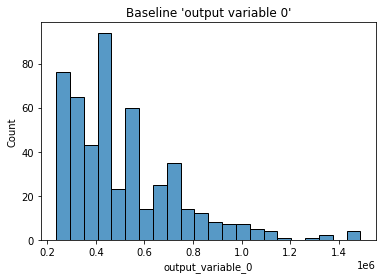

In [215]:
assay_builder.baseline_histogram()

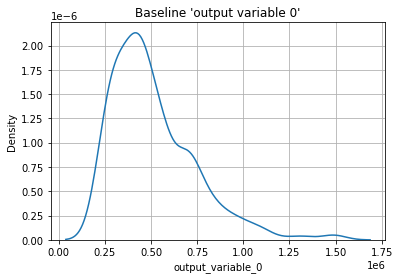

In [216]:
assay_builder.baseline_kde()

In [217]:
assay_config = assay_builder.build()
print(assay_config.to_json())

Please log into the following URL in a web browser:

	https://keycloak.autoscale-uat-ee.wallaroo.dev/auth/realms/master/device?user_code=RVVY-IDKW

Login successful!
{
    "name": "houseprice by baseline values",
    "pipeline_id": 205,
    "pipeline_name": "housepricesagapipeline",
    "active": true,
    "status": "created",
    "baseline": {
        "static": {
            "count": 500,
            "min": 236238.67,
            "max": 1489624.3,
            "mean": 512830.75258000026,
            "median": 450867.7,
            "std": 228280.22220663528,
            "edges": [
                236238.67,
                316231.84,
                431929.2,
                513583.06,
                687786.44,
                1489624.3,
                null
            ],
            "edge_names": [
                "left_outlier",
                "q_20",
                "q_40",
                "q_60",
                "q_80",
                "q_100",
                "right_outlier"
   

Now we'll perform some inferences with a spread of values, then a larger set with a set of larger house values to trigger our assay alert.

Because our assay windows are 1 minutes, we'll need to stagger our inference values to be set into the proper windows.  This will take about 4 minutes.

In [150]:
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()

mainpipeline.deploy(deployment_config = deploy_config)

Waiting for deployment - this will take up to 45s ......... ok


name,housepricesagapipeline
created,2023-10-16 15:40:16.732820+00:00
last_updated,2023-10-16 19:46:04.535243+00:00
deployed,True
tags,
versions,"11af088b-fb7e-49df-a52b-a878c90e82d8, 804877a5-0b3c-48df-b529-0e6ac431123e, b62aa586-01f5-4c09-a827-4501cd9c07c1"
steps,housepricesagacontrol
published,False


In [221]:
mainpipeline.status()

{'status': 'Running',
 'details': [],
 'engines': [{'ip': '10.244.0.163',
   'name': 'engine-84f9b4d885-wwvvt',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'housepricesagapipeline',
      'status': 'Running'}]},
   'model_statuses': {'models': [{'name': 'housepricesagacontrol',
      'version': 'cb80b7bb-3a5c-4427-b962-ee2b0ebd10be',
      'sha': 'e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6',
      'status': 'Running'}]}}],
 'engine_lbs': [{'ip': '10.244.0.164',
   'name': 'engine-lb-584f54c899-hgrqz',
   'status': 'Running',
   'reason': None,
   'details': []}],
 'sidekicks': []}

In [224]:
# Get a spread of house values

# regular_houses_inputs = pd.read_json('./data/xtest-1k.df.json', orient="records")
inference_size = 1000

# regular_houses = regular_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

# And a spread of large house values

big_houses_inputs = pd.read_json('./data/biginputs.df.json', orient="records")
big_houses = big_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

# Set the start for our assay window period.
assay_window_start = datetime.datetime.now()

# time.sleep(35)
mainpipeline.infer(big_houses)
# time.sleep(35)

# Run a set of regular house values, spread across 90 seconds
# for x in range(3):
    # mainpipeline.infer(regular_houses)
    # time.sleep(35)
    # mainpipeline.infer(big_houses)
    # time.sleep(35)

# End our assay window period
assay_window_end = datetime.datetime.now()

In [225]:
# now set up our interactive assay based on the window set above.

assay_builder = assay_builder.add_run_until(assay_window_end)

# We don't have many records at the moment, so set the width to 1 minute so it'll slice each 
# one minute interval into a window to analyze
assay_builder.window_builder().add_width(minutes=1).add_interval(minutes=1)

# Build the assay and then do an interactive run rather than waiting for the next interval
assay_config = assay_builder.build()
assay_results = assay_config.interactive_run()

Generated 7 analyses


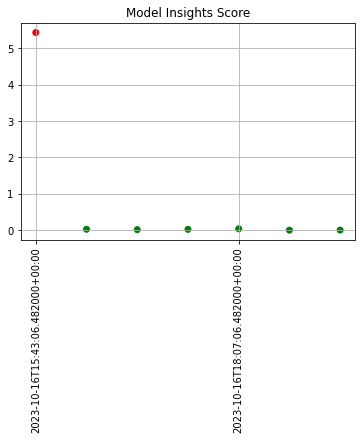

In [226]:
# Show how many assay windows were analyzed, then show the chart
print(f"Generated {len(assay_results)} analyses")
assay_results.chart_scores()

In [227]:
# Display the results as a DataFrame - we're mainly interested in the score and whether the 
# alert threshold was triggered
display(assay_results.to_dataframe().loc[:, ["score", "start", "alert_threshold", "status"]])

,score,start,alert_threshold,status
0,5.431772,2023-10-16T15:43:06.482000+00:00,0.25,Alert
1,0.025529,2023-10-16T15:56:06.482000+00:00,0.25,Ok
2,0.014434,2023-10-16T17:25:06.482000+00:00,0.25,Ok
3,0.023169,2023-10-16T18:05:06.482000+00:00,0.25,Ok
4,0.036520,2023-10-16T18:07:06.482000+00:00,0.25,Ok
5,0.000520,2023-10-16T19:56:06.482000+00:00,0.25,Ok
6,0.002604,2023-10-16T22:03:06.482000+00:00,0.25,Ok


### Upload Assay

With the assay created and fully tested, we will upload it to the Wallaroo instance.  This will make it available for future demonstrations and visible through the Wallaroo UI.

In [28]:
assay_builder.upload()

4

The assay is now visible through the Wallaroo UI by selecting the workspace, then the pipeline, then **Insights**.

![Sample assay in the UI](./images/housepricesaga-sample-assay.png)

### Undeploy Main Pipeline

With the examples and tutorial complete, we will undeploy the main pipeline and return the resources back to the Wallaroo instance.

In [29]:
mainpipeline.undeploy()

name,housepricesagapipeline
created,2023-07-19 19:40:14.556167+00:00
last_updated,2023-07-26 16:24:36.821419+00:00
deployed,False
tags,
versions,"98e71425-1842-46d3-bc4e-1b1f88cedf42, 3170fb20-b0e4-4fdf-89d2-ca1444c1bcf8, 75ca4917-af81-4b47-884a-98ad67fa138f, 23f98d7c-27d7-456d-b85f-b69be85b6ebe, 57cd5d2b-316a-4ed6-8730-4a88ee251d93, 2513fed6-ad9e-48da-9830-716d81bd2f42, 34fbdbd2-37b6-4c87-a73b-2bc37356f107, 85f43a06-6a2d-445e-9ba7-6511a7c8300c, 6f21cab0-689d-4c7a-be9a-317786a1173d, ee06f9e2-56d8-413d-8245-0fb37dc377ed, ccad17d0-8121-42ac-9311-14777667ae61, a77de963-1df0-4f2f-92d7-cc010277e726, 44f668f8-938c-4542-8c79-13128891171c, 423875eb-d31a-48fa-bcc5-a3fe4d45e4d9"
steps,housepricesagacontrol
